<a href="https://colab.research.google.com/github/kej534923-maker/ECON5200-Applied-Data-Analytics/blob/main/Econ_5200_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 1: Prepare (Logic & Control Flow)

Step 1.1: Construct the "Student Basket"

In [3]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    {'Item': 'ChatGPT Plus (1 mo)', 'Price_2016': 10, 'Price_2024': 20}
]

Step 1.2: Compute Inflation (Loops & Functions)

In [4]:
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

In [5]:
for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")

Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation
ChatGPT Plus (1 mo): 100.00% Inflation


Phase 2: Process (The API Pipeline)

Step 2.1: The "Data Proxy" Strategy

In [6]:
!pip install fredapi

import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

fred = Fred(api_key='f5b679a5d8fef7eae0033bc168a0f17c')

In [7]:
official_cpi = fred.get_series('CPIAUCSL')          # Headline CPI
tuition      = fred.get_series('CUSR0000SEEB')      # Tuition, Fees, & Childcare
rent         = fred.get_series('CUSR0000SEHA')      # Rent of Primary Residence
chatgpt      = fred.get_series('CUSR0000SERA02')    # Proxy for subscriptions (Spotify/ChatGPT/Netflix etc.)
food_away    = fred.get_series('CUSR0000SEFV')      # Food Away From Home (proxy for Chipotle)

In [8]:
df = pd.DataFrame({
    'Official_CPI': official_cpi,
    'Tuition': tuition,
    'Rent': rent,
    'ChatGPT_Proxy': chatgpt,
    'Food_Away_From_Home': food_away
})
df = df.dropna()
print(df.head())
print(df.tail())


            Official_CPI  Tuition   Rent  ChatGPT_Proxy  Food_Away_From_Home
1992-01-01         138.3    200.7  145.4          180.8                139.8
1992-02-01         138.6    201.9  145.7          181.8                140.0
1992-03-01         139.1    203.5  146.5          183.3                140.1
1992-04-01         139.4    205.0  146.2          186.2                140.2
1992-05-01         139.7    206.3  146.5          185.2                140.4
            Official_CPI  Tuition     Rent  ChatGPT_Proxy  Food_Away_From_Home
2025-07-01       322.132  893.568  436.152        594.484              383.808
2025-08-01       323.364  895.305  437.462        592.604              384.909
2025-09-01       324.368  897.302  438.322        593.928              385.451
2025-11-01       325.031  902.001  438.875        599.226              387.202
2025-12-01       326.030  903.402  440.034        605.825              389.889


Step 2.2: Normalization Logic (CRITICAL)

In [9]:
def normalize_series(value_col, start_date):

    base_value = value_col.loc[start_date]

    # The Formula: (Value_Current / Value_at_Start_Date) * 100
    indexed_col = (value_col / base_value) * 100

    return indexed_col


In [10]:
start_date = "2016-01-01"

df_indexed = df.copy()

for col in df.columns:
    df_indexed[col] = normalize_series(df[col], start_date)

print(df_indexed.loc[start_date])


Official_CPI           100.0
Tuition                100.0
Rent                   100.0
ChatGPT_Proxy          100.0
Food_Away_From_Home    100.0
Name: 2016-01-01 00:00:00, dtype: float64


Phase 3: Analyze (The Index Theory & Visualization)

Step 3.1: Visualizing Raw Components

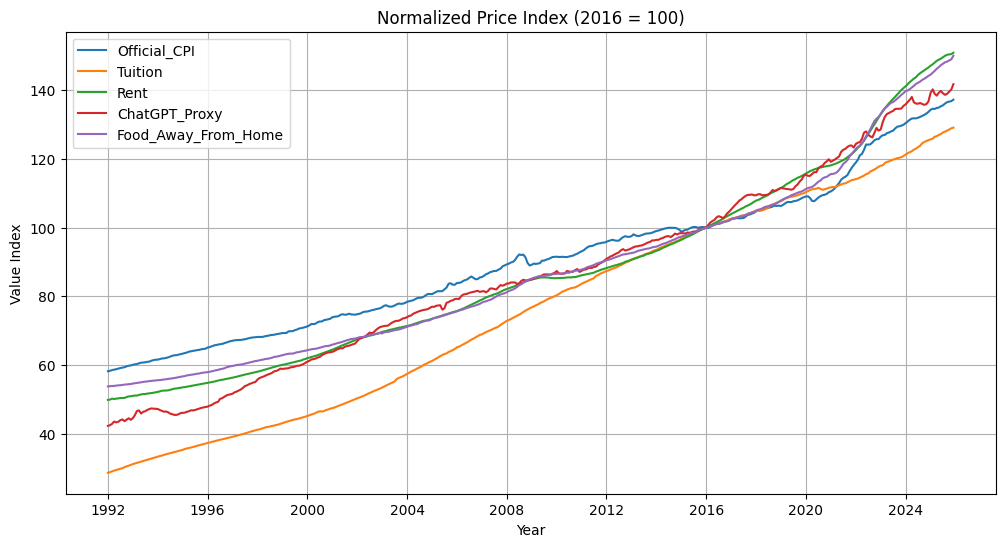

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for col in df_indexed.columns:
    plt.plot(df_indexed.index, df_indexed[col], label=col)
plt.title("Normalized Price Index (2016 = 100)")
plt.xlabel("Year")
plt.ylabel("Value Index")
plt.legend()
plt.grid(True)
plt.show()


Step 3.2: The Weighted "Student SPI" (Honest Chart)

In [18]:
weights = {
    'Tuition': 0.40,
    'Rent': 0.30,
    'Food_Away_From_Home': 0.15,
    'ChatGPT_Proxy': 0.05,
    'Official_CPI': 0.10
}
print(sum(weights.values()))

1.0


In [19]:
df_indexed['Student_SPI'] = 0
for item, weight in weights.items():
    df_indexed['Student_SPI'] += df_indexed[item] * weight

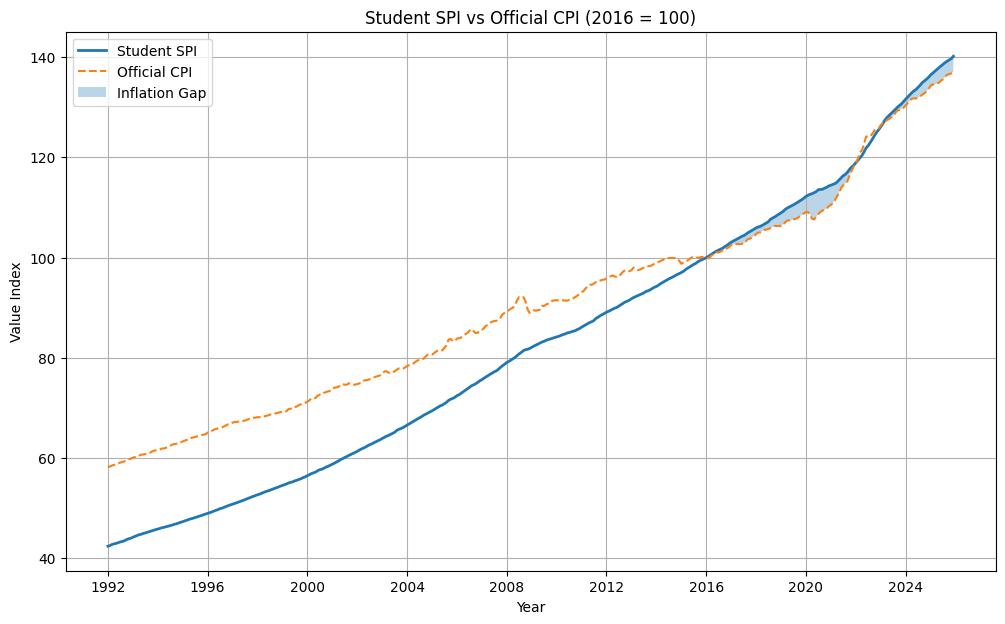

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.plot(df_indexed.index, df_indexed['Student_SPI'],
         label='Student SPI', linewidth=2)
plt.plot(df_indexed.index, df_indexed['Official_CPI'],
         label='Official CPI', linestyle='--')
plt.fill_between(
    df_indexed.index,
    df_indexed['Student_SPI'],
    df_indexed['Official_CPI'],
    where=(df_indexed['Student_SPI'] > df_indexed['Official_CPI']),
    alpha=0.3,
    label='Inflation Gap'
)
plt.title('Student SPI vs Official CPI (2016 = 100)')
plt.xlabel('Year')
plt.ylabel('Value Index')
plt.legend()
plt.grid(True)
plt.show()


Step 3.3: The Scale Fallacy (Why We Normalize)

Fetching RAW series from FRED...


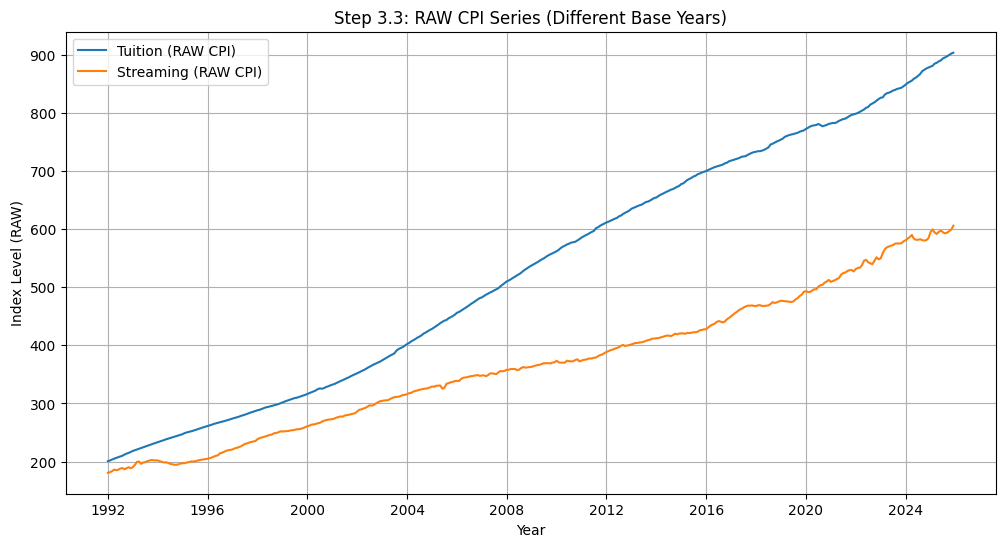

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
print("Fetching RAW series from FRED...")

cpi_tuition = fred.get_series('CUSR0000SEEB')     # Tuition, Fees, & Childcare
cpi_streaming = fred.get_series('CUSR0000SERA02') # Cable & Streaming TV (proxy)
raw_df = pd.DataFrame({
    'Tuition_CPI_RAW': cpi_tuition,
    'Streaming_CPI_RAW': cpi_streaming
}).dropna()
plt.figure(figsize=(12, 6))
plt.plot(raw_df.index, raw_df['Tuition_CPI_RAW'], label='Tuition (RAW CPI)')
plt.plot(raw_df.index, raw_df['Streaming_CPI_RAW'], label='Streaming (RAW CPI)')
plt.title("Step 3.3: RAW CPI Series (Different Base Years)")
plt.xlabel("Year")
plt.ylabel("Index Level (RAW)")
plt.legend()
plt.grid(True)
plt.show()


### Step 3.3: Why Comparing RAW Indices is a "Data Crime"

The raw CPI series are reported with different base years (index definitions).  
For example, the tuition CPI may be indexed to a base period such that its level is around 900, while the streaming CPI may be indexed to a different base period such that its level is around 100.

Because these index levels are anchored to different base-year scales, comparing 900 vs 100 is meaningless.  
The chart makes tuition look “huge” and streaming look “tiny,” but that visual difference mainly reflects different base-year normalization, not actual relative inflation.

To make a valid comparison, we must re-index both series to a common start date (e.g., 2016 = 100).  
Only then do the lines represent comparable percentage growth over time.


Phase 4: AI Dashboard Expansion

Task 4.1: The Ultimate Reality Check (Boston vs. USA vs. You)

df_indexed columns: ['Official_CPI', 'Tuition', 'Rent', 'ChatGPT_Proxy', 'Food_Away_From_Home', 'Student_SPI']


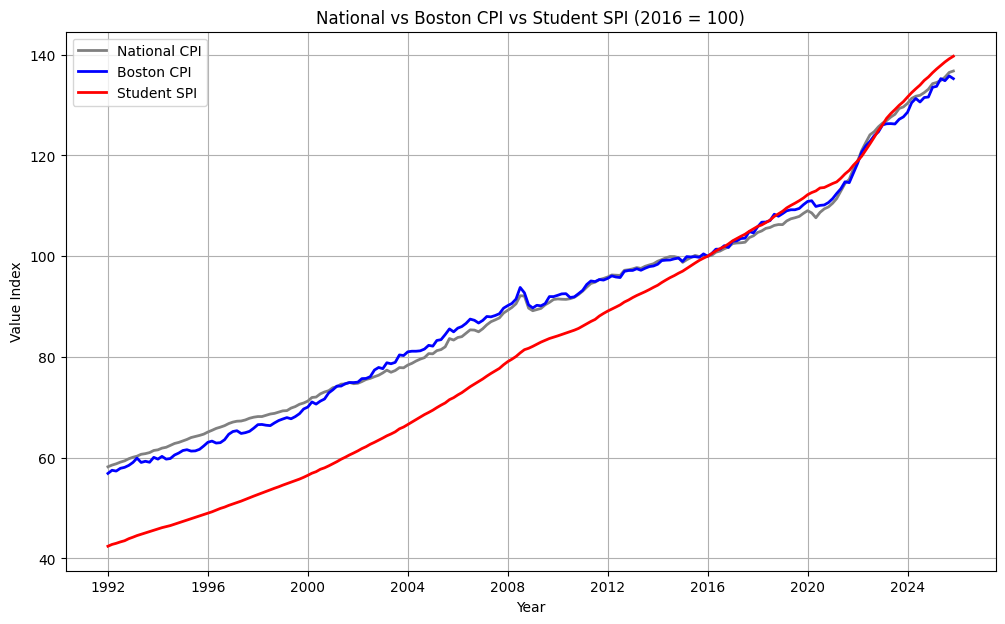

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Sanity check: ensure required columns exist ---
df_indexed.columns = df_indexed.columns.str.strip()
print("df_indexed columns:", df_indexed.columns.tolist())

# --- 1) Extract National CPI and Student SPI from df_indexed ---
plot_df = df_indexed[["Official_CPI", "Student_SPI"]].copy()
plot_df.index = pd.to_datetime(plot_df.index)
plot_df = plot_df.sort_index()

# --- 2) Fetch Boston CPI (RAW) from FRED and normalize to 2016 = 100 ---
boston_raw = fred.get_series("CUURA103SA0")
boston_raw.index = pd.to_datetime(boston_raw.index)
boston_raw = boston_raw.sort_index()

# Boston CPI is often bimonthly; resample to monthly and forward-fill
boston_monthly = boston_raw.resample("MS").ffill()

# Normalize: January 2016 = 100
base_date = pd.Timestamp("2016-01-01")
if base_date not in boston_monthly.index:
    base_date = boston_monthly.index[
        boston_monthly.index.get_loc(pd.Timestamp("2016-01-01"), method="nearest")
    ]

boston_indexed = (boston_monthly / boston_monthly.loc[base_date]) * 100
boston_indexed.name = "Boston_CPI"

# --- 3) Combine all three series into a single DataFrame ---
plot_df = plot_df.join(boston_indexed, how="inner").dropna()

# --- 4) Plot: National CPI vs Boston CPI vs Student SPI ---
plt.figure(figsize=(12, 7))

plt.plot(plot_df.index, plot_df["Official_CPI"],
         label="National CPI", color="grey", linewidth=2)

plt.plot(plot_df.index, plot_df["Boston_CPI"],
         label="Boston CPI", color="blue", linewidth=2)

plt.plot(plot_df.index, plot_df["Student_SPI"],
         label="Student SPI", color="red", linewidth=2)

plt.title("National vs Boston CPI vs Student SPI (2016 = 100)")
plt.xlabel("Year")
plt.ylabel("Value Index")
plt.legend()
plt.grid(True)

plt.show()


